In [ ]:
import numpy as np
import pandas as pd
import missingno as miss
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [ ]:
df_train = pd.read_csv('train.csv', index_col='PassengerId')
df_test = pd.read_csv('test.csv', index_col='PassengerId')

test_target = pd.read_csv('gender_submission.csv', index_col='PassengerId')

In [ ]:
df_test['Survived'] = test_target
df_train['type'] = 'train'
df_test['type'] = 'test'

df = df_train.append(df_test, sort=False)

df.reset_index(drop=True, inplace=True)

In [ ]:
target = df[['Survived', 'type']]
# df.drop(columns=['Survived'], inplace=True)

In [ ]:
df.rename(columns={'Survived': 'target',
                   'Pclass': 'ticket_class', 
                   'Name': 'name', 
                   'Sex': 'sex',
                   'Age': 'age',
                   'SibSp': 'spouses', 
                   'Parch': 'children', 
                   'Ticket': 'ticket_num', 
                   'Fare': 'ticket_price', 
                   'Cabin': 'cabin_num',
                   'Embarked': 'port_type'}, inplace=True)

In [ ]:
df

,target,ticket_class,name,sex,age,spouses,children,ticket_num,ticket_price,cabin_num,port_type,type
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test
1305,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test
1306,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test
1307,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test


# Plan:
1. Exploratory Data Analysis (EDA)
2. Feature Engineering
3. Choosing the Best Model
4. Hyperparameter Tuning

# Exploratory Data Analysis (EDA)

## Nans analysis

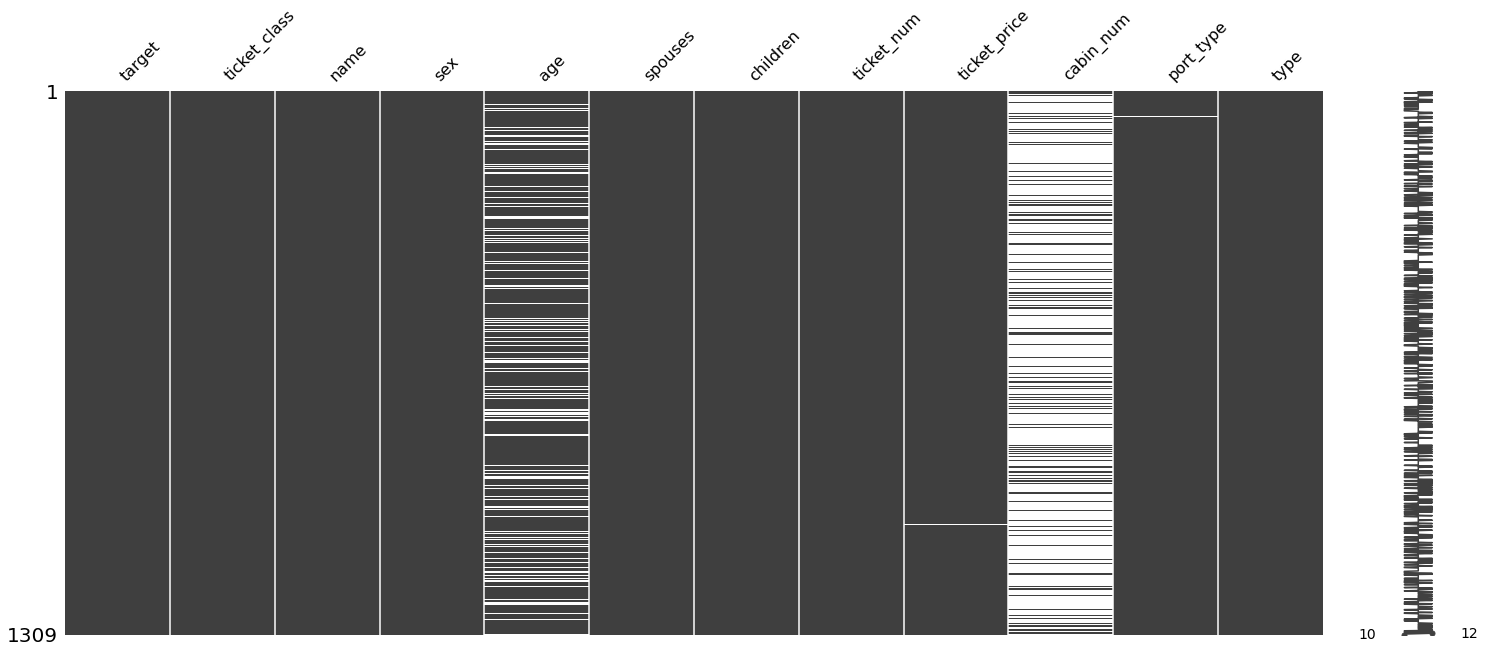

In [ ]:
miss.matrix(df);

In [ ]:
 def missing_value_table(df):
    mis_val = df.isna().sum()
    mis_val_percent = round(100 * mis_val / len(df), 2)
    dtype = df.dtypes

    mis_val_table = pd.concat([mis_val, mis_val_percent, dtype], axis=1)
    mis_val_table.rename(columns={0: 'Missing Values', 
                                1: '% of Total Values',
                                2: 'Data Types'}, inplace=True)

    mis_val_table = mis_val_table[mis_val_table['Missing Values'] > 0].sort_values(by='Missing Values',
                                                                                ascending=False)
    return mis_val_table

In [ ]:
missing_value_table(df)

,Missing Values,% of Total Values,Data Types
cabin_num,1014,77.46,object
age,263,20.09,float64
port_type,2,0.15,object
ticket_price,1,0.08,float64


From the above table we can see that 
1. ~80% of the Cabin values are missing \
    Solution: make nan values as group
2. ~20% of the age values are missing \
    Solution: use KNNimputer or another type of imputers

In [ ]:
cat_f = []
num_f = []

## Feature Analysis

 ### Target

In [ ]:
survived_per = round(df[df['target'] == 1].shape[0] / df.shape[0] * 100)
not_survived_per = round(df[df['target'] == 0].shape[0] / df.shape[0] * 100)

In [ ]:
# plt.bar(x=['Survived', 'Not Survived'], height=[survived_per, not_survived_per], color=['mediumturquoise', 'lightsalmon'])
# plt.ylabel('Percentage')
# plt.title("Survival Rate Distribution")
# plt.grid()
# plt.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['Survived', 'Not Survived'],
                     y=[survived_per, not_survived_per], 
                     marker_color=["mediumturquoise", "lightsalmon"]))

fig.update_layout(width=600, 
                  height=400,
                  xaxis_title="Survived or Not",
                  yaxis_title="Percentage",
                  title={
                      'text': "Survival Rate Distribution",
                      'y':0.9,
                      'x':0.5, 
                      'xanchor': 'center', 
                      'yanchor': 'top'})

fig.show();

Most of the people could not survive

### Ticket class

In [ ]:
df['ticket_class'].unique()

array([3, 1, 2])

Tickets are devided into three classes:
1. ticket_class == 1 refers to **first class**
2. ticket_class == 2 refers to **second class**
3. ticket_class == 3 refers to **third class**


In [ ]:
# sns.countplot(x='ticket_class', hue='target', data=df)
# plt.legend(labels=['Not Survived','Survived'])
# plt.grid()

In [ ]:
def gbplot(df, feature):
    survived_with_f = df.groupby(by=[feature]).sum()['target']
    all_with_f = df.groupby(by=[feature]).count()['target']
    not_survived_with_f = all_with_f - survived_with_f

    f_sizes = list(survived_with_f.index)

    fig = go.Figure(data=[go.Bar(name='Survived',
                                x=f_sizes,
                                y=survived_with_f,
                                marker_color='mediumturquoise'),
                          go.Bar(name='Not Survived',
                                x=f_sizes,
                                y=not_survived_with_f, 
                                marker_color='lightsalmon')])

    fig.update_xaxes(type='category')

    fig.update_layout(width=1000,
                      height=500,
                      barmode='group',
                      xaxis = dict(title=feature),
                      yaxis = dict(title="Passenger Count"))
    fig.update_layout(
        title={
            'text': str("Survival Count with respect to " + feature),
            'y':0.9,
            'x':0.45,
            'xanchor': 'center',
            'yanchor': 'top'})

    fig.show()

In [ ]:
gbplot(df, 'ticket_class')

First class > second class > third class survival rate. So ticket class has an impact on passenger's survival

In [ ]:
cat_f.append('ticket_class')

### Name

There is person type in the name of each passenger. So let's make categorical feature with it.

In [ ]:
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    return np.nan

title_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev', 
              'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess', 
              'Don', 'Jonkheer']
df['title'] = df['name'].map(lambda x: substrings_in_string(x, title_list))

#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title = x['title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title == 'Dr':
        if x['sex'] == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

df['title'] = df.apply(replace_titles, axis=1)
df.drop(columns=['name'], inplace=True)

In [ ]:
df

,target,ticket_class,sex,age,spouses,children,ticket_num,ticket_price,cabin_num,port_type,type,title
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,Mr
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,train,Mrs
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,Miss
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,train,Mrs
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,train,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test,Mr
1305,1,1,female,39.0,0,0,PC 17758,108.9000,C105,C,test,Mr
1306,0,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test,Mr
1307,0,3,male,NaN,0,0,359309,8.0500,NaN,S,test,Mr


In [ ]:
df['title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

In [ ]:
# sns.countplot(x='title', hue='target', data=df)
# plt.legend(labels=['Not Survived','Survived'])
# plt.grid()

In [ ]:
gbplot(df, 'title')

In [ ]:
cat_f.append('title')

### Sex

In [ ]:
# sns.countplot(x='sex', hue='target', data=df)
# plt.legend(labels=['Not Survived','Survived'])
# plt.grid()

In [ ]:
gbplot(df, 'sex')

Women have higher survive rate then man

In [ ]:
cat_f.append('sex')

### Family features

Let's create a new Family size feature. It'll contain two categorical features 'spouses' and 'children'.

In [ ]:
df['family_size'] = df['spouses'] + df['children']

In [ ]:
df['family_size'].unique()

array([ 1,  0,  4,  2,  6,  5,  3,  7, 10])

In [ ]:
# sns.countplot(x='family_size', data=df)
# plt.title('Family size distribution')
# plt.grid()
# plt.show()

In [ ]:
gbplot(df, 'family_size')

In [ ]:
# sns.countplot(x='family_size', hue='target', data=df)
# plt.legend(labels=['Not Survived','Survived'])
# plt.grid()
# plt.title('Survival count with respect to Family size')
# plt.show()

In [ ]:
total = df.groupby(by='family_size').count()['target']
survived = df.groupby(by='family_size').sum()['target']
survived_per = pd.DataFrame(round(survived / total * 100)).reset_index()

In [ ]:
# sns.barplot(x='family_size', y='target', data=survived_per)
# plt.grid()
# plt.title("Survival Rate with respect to Family Size")
# plt.show()

In [ ]:
fig = go.Figure()

fig.add_traces(go.Bar(x=survived_per['family_size'],
                      y=survived_per['target'], 
                      marker_color=survived_per['target']))

fig.update_xaxes(type='category')

fig.update_layout(width=1000,
                  height=500,
                  barmode='group',
                  xaxis = dict(title="Family size"),
                  yaxis = dict(title="Survival Percentage"))
fig.update_layout(
    title={
        'text': "Survival Rate with respect to Family Size",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

We have more survived passengers when family size is equal to 1, 2 or 3. So let's devide passengers into three groups:
1. Single passengers, when family_size == 0
2. Small family, when family_size $\in [1, 2, 3]$
3. Big family, when family_size is 4 and higher

In [ ]:
df.loc[df['family_size'] == 0, 'family_type'] = 1
df.loc[df['family_size'].isin([1, 2, 3]), 'family_type'] = 2
df.loc[df['family_size'].isin([4, 5, 6, 7, 10]), 'family_type'] = 3

df['family_type'] = df['family_type'].astype('int64')

In [ ]:
df.drop(columns=['spouses', 'children', 'family_size'], inplace=True)

In [ ]:
df['family_type'].unique()

array([2, 1, 3])

In [ ]:
df

,target,ticket_class,sex,age,ticket_num,ticket_price,cabin_num,port_type,type,title,family_type
0,0,3,male,22.0,A/5 21171,7.2500,NaN,S,train,Mr,2
1,1,1,female,38.0,PC 17599,71.2833,C85,C,train,Mrs,2
2,1,3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,train,Miss,1
3,1,1,female,35.0,113803,53.1000,C123,S,train,Mrs,2
4,0,3,male,35.0,373450,8.0500,NaN,S,train,Mr,1
...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,male,NaN,A.5. 3236,8.0500,NaN,S,test,Mr,1
1305,1,1,female,39.0,PC 17758,108.9000,C105,C,test,Mr,1
1306,0,3,male,38.5,SOTON/O.Q. 3101262,7.2500,NaN,S,test,Mr,1
1307,0,3,male,NaN,359309,8.0500,NaN,S,test,Mr,1


In [ ]:
# sns.countplot(x='family_type', data=df)
# plt.title('Survival count with respect to Family Type')
# plt.grid()
# plt.show()

In [ ]:
survived_with_fam = df.groupby(by=['family_type']).sum()['target']
all_with_fam = df.groupby(by=['family_type']).count()['target']

survived_with_fam_per = round(survived_with_fam / all_with_fam * 100)

family_sizes = list(survived_with_fam_per.index)

fig = go.Figure()

fig.add_trace(go.Bar(x=family_sizes,
                     y=survived_with_fam_per,
                     marker_color=survived_with_fam_per))

fig.update_xaxes(type='category')

fig.update_layout(width=600,
                  height=400,
                  barmode='group',
                  xaxis = dict(title="Family Category"),
                  yaxis = dict(title="Survival Percentage"))
fig.update_layout(
    title={
        'text': "Survival Rate with respect to Family Category",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

In [ ]:
cat_f.append('family_type')

### Port Type

In [ ]:
df['port_type'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [ ]:
# sns.countplot(x='port_type', hue='target', data=df)
# plt.legend(labels=['Not Survived','Survived'])
# plt.grid()

In [ ]:
gbplot(df, 'port_type')

Turns out that Ported Embarked is not a redundant feature. As we can see that, Embarked = S has a lower survival rate than other groups.

In [ ]:
df.loc[df['port_type'].isna() == True, 'port_type'] = df['port_type'].mode()[0]

In [ ]:
cat_f.append('port_type')

### Ticket number

In [ ]:
gb = pd.DataFrame(df.groupby(by='ticket_num').size(), columns=['num']).reset_index()

In [ ]:
df = df.merge(gb, how='left', left_on=['ticket_num'], right_on=['ticket_num'])
df.rename(columns={'num': 'ticket_count'}, inplace=True)

In [ ]:
df

,target,ticket_class,sex,age,ticket_num,ticket_price,cabin_num,port_type,type,title,family_type,ticket_count
0,0,3,male,22.0,A/5 21171,7.2500,NaN,S,train,Mr,2,1
1,1,1,female,38.0,PC 17599,71.2833,C85,C,train,Mrs,2,2
2,1,3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,train,Miss,1,1
3,1,1,female,35.0,113803,53.1000,C123,S,train,Mrs,2,2
4,0,3,male,35.0,373450,8.0500,NaN,S,train,Mr,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,male,NaN,A.5. 3236,8.0500,NaN,S,test,Mr,1,1
1305,1,1,female,39.0,PC 17758,108.9000,C105,C,test,Mr,1,3
1306,0,3,male,38.5,SOTON/O.Q. 3101262,7.2500,NaN,S,test,Mr,1,1
1307,0,3,male,NaN,359309,8.0500,NaN,S,test,Mr,1,1


In [ ]:
# sns.countplot(x='ticket_count', hue='target', data=df)
# plt.legend(labels=['Not Survived','Survived'])
# plt.xlabel('Ticket groups')
# plt.ylabel('Amount of tickets')
# plt.title("Survival Count with respect to Ticket Count")
# plt.grid()
# plt.show()

In [ ]:
gbplot(df, 'ticket_count')

It seems that Ticket groups is highly correlated with family count from the survival count plot. Let's calculate the correlation.

In [ ]:
corr = df['ticket_count'].corr(df['family_type'])
print("The correlation is: {}".format(corr))

The correlation is: 0.6673116590927493


In [ ]:
df.loc[df['ticket_count'] == 1, 'ticket_type'] = 1
df.loc[df['ticket_count'].isin([2, 3, 4]), 'ticket_type'] = 2
df.loc[df['ticket_count'].isin([5, 6, 7, 8, 11]), 'ticket_type'] = 3

df['ticket_type'] = df['ticket_type'].astype('int64')

In [ ]:
df.drop(columns=['ticket_num', 'ticket_count'], inplace=True)

In [ ]:
df

,target,ticket_class,sex,age,ticket_price,cabin_num,port_type,type,title,family_type,ticket_type
0,0,3,male,22.0,7.2500,NaN,S,train,Mr,2,1
1,1,1,female,38.0,71.2833,C85,C,train,Mrs,2,2
2,1,3,female,26.0,7.9250,NaN,S,train,Miss,1,1
3,1,1,female,35.0,53.1000,C123,S,train,Mrs,2,2
4,0,3,male,35.0,8.0500,NaN,S,train,Mr,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,male,NaN,8.0500,NaN,S,test,Mr,1,1
1305,1,1,female,39.0,108.9000,C105,C,test,Mr,1,2
1306,0,3,male,38.5,7.2500,NaN,S,test,Mr,1,1
1307,0,3,male,NaN,8.0500,NaN,S,test,Mr,1,1


In [ ]:
cat_f.append('ticket_type')

###  Cabin num

In [ ]:
df[df['cabin_num'].isna() == False]

,target,ticket_class,sex,age,ticket_price,cabin_num,port_type,type,title,family_type,ticket_type
1,1,1,female,38.0,71.2833,C85,C,train,Mrs,2,2
3,1,1,female,35.0,53.1000,C123,S,train,Mrs,2,2
6,0,1,male,54.0,51.8625,E46,S,train,Mr,1,2
10,1,3,female,4.0,16.7000,G6,S,train,Miss,2,2
11,1,1,female,58.0,26.5500,C103,S,train,Miss,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1295,0,1,male,43.0,27.7208,D40,C,test,Mr,2,1
1296,0,2,male,20.0,13.8625,D38,C,test,Mr,1,1
1298,0,1,male,50.0,211.5000,C80,C,test,Mr,2,3
1302,1,1,female,37.0,90.0000,C78,Q,test,Mrs,2,2


In [ ]:
gb = pd.DataFrame(df.groupby(by='cabin_num').size(), columns=['num']).reset_index()

In [ ]:
df = df.merge(gb, how='left', left_on=['cabin_num'], right_on=['cabin_num'])
df.rename(columns={'num': 'cabin_count'}, inplace=True)

In [ ]:
df

,target,ticket_class,sex,age,ticket_price,cabin_num,port_type,type,title,family_type,ticket_type,cabin_count
0,0,3,male,22.0,7.2500,NaN,S,train,Mr,2,1,NaN
1,1,1,female,38.0,71.2833,C85,C,train,Mrs,2,2,2.0
2,1,3,female,26.0,7.9250,NaN,S,train,Miss,1,1,NaN
3,1,1,female,35.0,53.1000,C123,S,train,Mrs,2,2,2.0
4,0,3,male,35.0,8.0500,NaN,S,train,Mr,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,male,NaN,8.0500,NaN,S,test,Mr,1,1,NaN
1305,1,1,female,39.0,108.9000,C105,C,test,Mr,1,2,1.0
1306,0,3,male,38.5,7.2500,NaN,S,test,Mr,1,1,NaN
1307,0,3,male,NaN,8.0500,NaN,S,test,Mr,1,1,NaN


In [ ]:
# sns.countplot(x='cabin_count', hue='target', data=df)
# plt.legend(labels=['Not Survived','Survived'])
# plt.xlabel('Ticket groups')
# plt.ylabel('Amount of tickets')
# plt.title("Survival Count with respect to Ticket Count")
# plt.grid()
# plt.show()

In [ ]:
gbplot(df, 'cabin_count')

We have more survived passengers when ticket count is equal to 2 or higher. So let's devide passengers into three groups:
1. Single passengers, when ticket_count == 1
2. Family, when ticket_count is higher than 1
3. Nan values

In [ ]:
df.loc[df['cabin_count'] == 1, 'cabin_type'] = 1
df.loc[df['cabin_count'].isin([2, 3, 4, 5, 6]), 'cabin_type'] = 2
df.loc[df['cabin_count'].isna() == True, 'cabin_type'] = 3

df['cabin_type'] = df['cabin_type'].astype('int64')

In [ ]:
df.drop(columns=['cabin_num', 'cabin_count'], inplace=True)

In [ ]:
df

,target,ticket_class,sex,age,ticket_price,port_type,type,title,family_type,ticket_type,cabin_type
0,0,3,male,22.0,7.2500,S,train,Mr,2,1,3
1,1,1,female,38.0,71.2833,C,train,Mrs,2,2,2
2,1,3,female,26.0,7.9250,S,train,Miss,1,1,3
3,1,1,female,35.0,53.1000,S,train,Mrs,2,2,2
4,0,3,male,35.0,8.0500,S,train,Mr,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...
1304,0,3,male,NaN,8.0500,S,test,Mr,1,1,3
1305,1,1,female,39.0,108.9000,C,test,Mr,1,2,1
1306,0,3,male,38.5,7.2500,S,test,Mr,1,1,3
1307,0,3,male,NaN,8.0500,S,test,Mr,1,1,3


In [ ]:
cat_f.append('cabin_type')

In [ ]:
cat_f

['ticket_class',
 'title',
 'sex',
 'family_type',
 'port_type',
 'ticket_type',
 'cabin_type']

In [ ]:
num_f = ['age', 'ticket_price']
num_f

['age', 'ticket_price']

### OneHotEncoder

In [ ]:
df.isna().sum()

target            0
ticket_class      0
sex               0
age             263
ticket_price      1
port_type         0
type              0
title             0
family_type       0
ticket_type       0
cabin_type        0
dtype: int64

In [ ]:
X_train = df[df['type'] == 'train'].drop(columns=['target', 'type'])
X_test = df[df['type'] == 'test'].drop(columns=['target', 'type'])

In [ ]:
X_train[cat_f].isna().sum()

ticket_class    0
title           0
sex             0
family_type     0
port_type       0
ticket_type     0
cabin_type      0
dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train[cat_f])
X_train_ohe = pd.DataFrame(X_train_ohe.toarray(), columns=ohe.get_feature_names(cat_f))

X_test_ohe = ohe.fit_transform(X_test[cat_f])
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=ohe.get_feature_names(cat_f))

In [ ]:
X_train_ohe[num_f] = X_train[num_f]
X_test_ohe[num_f] = X_test[num_f].reset_index(drop=True)

In [ ]:
X_train_ohe

,ticket_class_1,ticket_class_2,ticket_class_3,title_Master,title_Miss,title_Mr,title_Mrs,sex_female,sex_male,family_type_1,family_type_2,family_type_3,port_type_C,port_type_Q,port_type_S,ticket_type_1,ticket_type_2,ticket_type_3,cabin_type_1,cabin_type_2,cabin_type_3,age,ticket_price
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,22.0,7.2500
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,38.0,71.2833
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,26.0,7.9250
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,35.0,53.1000
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,35.0,8.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,27.0,13.0000
887,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,19.0,30.0000
888,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,23.4500
889,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,26.0,30.0000


###Nan's replacement with KNNimputer

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
X_train = pd.DataFrame(imputer.fit_transform(X_train_ohe), columns=X_train_ohe.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test_ohe), columns=X_test_ohe.columns)

# Model

In [ ]:
y_train = np.array(target[target['type'] == 'train']['Survived'])
y_test = np.array(target[target['type'] == 'test']['Survived'])

In [ ]:
print(X_train.shape[0] == y_train.shape[0])
print(X_test.shape[0] == y_test.shape[0])

True
True


In [ ]:
# !pip install catboost

In [ ]:
# !pip install xgboost

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

In [ ]:
# Define scoring and StratifiedKFold
scoring = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']
cv = StratifiedKFold(5, shuffle=True, random_state=42)

In [ ]:
min_max_scaler = MinMaxScaler()
X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_test.columns)

In [ ]:
# Dictionaries for plotting graph
accuracy = {}
f1 = {}
precision = {}
recall = {}
roc_auc = {}

After some preparation work, we can now fit the data into different models. The models considered in this notebook are:
1. SVC
2. RandomForest
3. LogisticRegression
4. DecisionTree
5. GradientBoosting
6. XGBoost
7. CatBoost

In [ ]:
models = [SVC(max_iter=5000000),
          RandomForestClassifier(),
          LogisticRegression(solver='liblinear'),
          DecisionTreeClassifier(),
          GradientBoostingClassifier(),
          XGBClassifier()]
model_name = ['SVC', 
              'Random_Forest', 
              'Logistic', 
              'Decision_Tree', 
              'Gradient_Boosting',
              'XGBoost']

In [ ]:
# Try different Models with Cross Validation

def add_scores(model, scoring):
    accuracy[model] = scoring['test_accuracy'].mean()
    f1[model] = scoring['test_f1'].mean()
    precision[model] = scoring['test_precision'].mean()
    recall[model] = scoring['test_recall'].mean()
    roc_auc[model] = scoring['test_roc_auc'].mean()

for i in range(len(models)):
    model = models[i]
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    add_scores(model_name[i], scores)

In [ ]:
from catboost import CatBoostClassifier, Pool

model_cat = CatBoostClassifier()

train_data_catboost = Pool(data=X_train, label=y_train)
scores = cross_validate(model_cat,
                        train_data_catboost.get_features(),
                        train_data_catboost.get_label(), 
                        cv=cv, 
                        scoring=scoring)
add_scores('CatBoostClassifier', scores)
model_name.append('CatBoost')
models.append(model_cat)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.6641780	total: 58.7ms	remaining: 11.7s
5:	learn: 0.6582539	total: 60.8ms	remaining: 10.1s
6:	learn: 0.6525232	total: 63.9ms	remaining: 9.06s
7:	learn: 0.6473983	total: 65.4ms	remaining: 8.11s
8:	learn: 0.6422460	total: 67.5ms	remaining: 7.43s
9:	learn: 0.6377609	total: 69.6ms	remaining: 6.89s
10:	learn: 0.6330996	total: 71.6ms	remaining: 6.44s
11:	learn: 0.6281344	total: 73.8ms	remaining: 6.08s
12:	learn: 0.6233525	total: 75.3ms	remaining: 5.71s
13:	learn: 0.6188592	total: 77.3ms	remaining: 5.44s
14:	learn: 0.6142606	total: 80.1ms	remaining: 5.26s
15:	learn: 0.6094831	total: 83ms	remaining: 5.1s
16:	learn: 0.6048828	total: 85.3ms	remaining: 4.93s
17:	learn: 0.6003006	total: 87.6ms	remaining: 4.78s
18:	learn: 0.5967398	total: 89.1ms	remaining: 4.6s
19:	learn: 0.5937320	total: 90.1ms	remaining: 4.41s
20:	learn: 0.5903318	total: 91.2ms	remaining: 4.25s
21:	learn: 0.5864067	total: 93.3ms	remaining: 4.15s
22:	le

In [ ]:
fig = make_subplots(
    rows=2, cols=3, subplot_titles=("Accuracy", "F1 Score", "Precision", "Recall", "ROC AUC")
)

fig.add_trace(go.Bar(x=list(accuracy.values()),
                     y=list(accuracy.keys()), 
                     marker_color='mediumseagreen',
                     orientation='h',
                          ), row=1, col=1)

fig.add_trace(go.Bar(x=list(f1.values()),
                     y=list(accuracy.keys()), 
                     marker_color='mediumseagreen',
                     orientation='h',
                          ), row=1, col=2)

fig.add_trace(go.Bar(x=list(precision.values()),
                     y=list(accuracy.keys()), 
                     marker_color='mediumseagreen',
                     orientation='h',
                          ), row=1, col=3)

fig.add_trace(go.Bar(x=list(recall.values()),
                     y=list(accuracy.keys()), 
                     marker_color='mediumseagreen',
                     orientation='h',
                          ), row=2, col=1)

fig.add_trace(go.Bar(x=list(roc_auc.values()),
                     y=list(accuracy.keys()), 
                     marker_color='mediumseagreen',
                     orientation='h',
                          ), row=2, col=2)

fig.update_xaxes(range=[0.8, 0.9], row=1, col=1)
fig.update_xaxes(range=[0.75, 0.85], row=1, col=2)
fig.update_xaxes(range=[0.75, 0.85], row=1, col=3)
fig.update_xaxes(range=[0.7, 0.8], row=2, col=1)
fig.update_xaxes(range=[0.75, 0.95], row=2, col=2)

fig.update_layout(showlegend=False)
fig.show()

It seems that **CatBoost** and **Gradient Boosting** are good model candidate, without any hyperparameter fitting. Next we will fit these models with different hyperparameters and choose the best tuned model.

## Hyperparameter Tuning

In [ ]:
best_models = {}
param_grid =  {'Gradient_Boosting': 
                                  {"n_estimators": [5, 50, 250, 500, 1000, 2000],
                                   "max_depth": [1,3,5],
                                   "learning_rate": [0.001, 0.005, 0.01]},
               
               'XGBoost': 
                        {"learning_rate": [0.1, 0.01, 0.001],
                         "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
                         "max_depth": [2, 4, 7, 10],
                         "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
                         "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
                         "reg_alpha": [0, 0.5, 1],
                         "reg_lambda": [1, 1.5, 2, 3, 4.5],
                         "min_child_weight": [1, 3, 5, 7],
                         "n_estimators": [100, 250, 500, 1000]},
               
               'CatBoost': 
                         {"learning_rate": [0.1, 0.01, 0.001],
                          "n_estimators": [100, 250, 500, 1000],
                          "max_depth": [2, 4, 7, 10]},
               
               'SVC':
                    {'C': [0.01, 0.025, 0.05, 0.075, 0.1], 
                     'gamma': [1,0.5, 0.1,0.01], 
                     'kernel': ['rbf', 'poly', 'sigmoid']},
               
               'Decision_Tree': 
                              {'criterion': ['gini', 'entropy'], 
                               'max_depth': [1, 2, 3, 5, 10, 20, 50, None], 
                               'min_samples_leaf': [2, 3, 5, 10, 20, 50, 100]},
               
               'Logistic': 
                         {'penalty': ['l1', 'l2'],
                          'C': [0.5, 0.1, 0.05, 0.01]},
               
               'Random_Forest':
                              {'max_depth': [1, 3, 5, 7],
                               'min_samples_leaf': [1, 2, 4, 6, 8],
                               'min_samples_split': [2, 4, 5, 6, 7, 10],
                               'n_estimators': [5, 10 ,20, 25, 50, 100]}}
for i in range(len(models)):
    model = models[i]
    grid = RandomizedSearchCV(model, param_grid[model_name[i]], cv=cv, scoring='accuracy', verbose=1)
    grid.fit(X_train, y_train)
    best_models[model_name[i]] = grid.best_estimator_
    print(grid.best_estimator_)
    print(grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=5000000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.8395078777226791
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning:

The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.8372481325717155
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
0.8350134957002071
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.8271420500910175
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   19.5s finished


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.8349946644906158
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   18.3s finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.001, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.5, reg_lambda=1.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.4, verbosity=1)
0.8394953235829515
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6417513	total: 688us	remaining: 171ms
1:	learn: 0.6003372	total: 1.54ms	remaining: 191ms
2:	learn: 0.5699872	total: 2.31ms	remaining: 190ms
3:	learn: 0.5459779	total: 3.08ms	remaining: 190ms
4:	learn: 0.5198682	total: 3.81ms	remaining: 187ms
5:	learn: 0.5023737	total: 4.55ms	remaining: 185ms
6:	learn: 0.4933542	total: 5.35ms	remaining: 186ms
7:	learn: 0.4786906	total: 6.1ms	remaining: 185ms
8:	learn: 0.4688498	total: 6.9

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Выходные данные были обрезаны до нескольких последних строк (5000).
510:	learn: 0.4995828	total: 640ms	remaining: 613ms
511:	learn: 0.4993363	total: 641ms	remaining: 611ms
512:	learn: 0.4990956	total: 643ms	remaining: 610ms
513:	learn: 0.4989374	total: 644ms	remaining: 609ms
514:	learn: 0.4987166	total: 645ms	remaining: 607ms
515:	learn: 0.4985222	total: 646ms	remaining: 606ms
516:	learn: 0.4982724	total: 647ms	remaining: 605ms
517:	learn: 0.4980817	total: 648ms	remaining: 603ms
518:	learn: 0.4978614	total: 650ms	remaining: 602ms
519:	learn: 0.4976473	total: 651ms	remaining: 601ms
520:	learn: 0.4974430	total: 652ms	remaining: 599ms
521:	learn: 0.4972268	total: 653ms	remaining: 598ms
522:	learn: 0.4969946	total: 654ms	remaining: 597ms
523:	learn: 0.4967757	total: 656ms	remaining: 596ms
524:	learn: 0.4965804	total: 657ms	remaining: 594ms
525:	learn: 0.4963758	total: 658ms	remaining: 593ms
526:	learn: 0.4961554	total: 660ms	remaining: 593ms
527:	learn: 0.4959920	total: 662ms	remaining: 59

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.8min finished


10:	learn: 0.6413104	total: 18.6ms	remaining: 1.67s
11:	learn: 0.6377462	total: 20.3ms	remaining: 1.67s
12:	learn: 0.6336767	total: 21.7ms	remaining: 1.65s
13:	learn: 0.6289982	total: 22.8ms	remaining: 1.6s
14:	learn: 0.6247147	total: 23.8ms	remaining: 1.56s
15:	learn: 0.6206611	total: 24.6ms	remaining: 1.51s
16:	learn: 0.6167055	total: 25.5ms	remaining: 1.47s
17:	learn: 0.6126346	total: 26.3ms	remaining: 1.43s
18:	learn: 0.6093636	total: 27.1ms	remaining: 1.4s
19:	learn: 0.6060127	total: 27.9ms	remaining: 1.37s
20:	learn: 0.6023835	total: 28.8ms	remaining: 1.34s
21:	learn: 0.5991894	total: 29.6ms	remaining: 1.32s
22:	learn: 0.5952897	total: 30.4ms	remaining: 1.29s
23:	learn: 0.5914845	total: 31.2ms	remaining: 1.27s
24:	learn: 0.5879697	total: 31.9ms	remaining: 1.24s
25:	learn: 0.5855072	total: 32.7ms	remaining: 1.22s
26:	learn: 0.5819338	total: 33.5ms	remaining: 1.21s
27:	learn: 0.5784469	total: 34.3ms	remaining: 1.19s
28:	learn: 0.5755366	total: 35.2ms	remaining: 1.18s
29:	learn: 0.5

In [ ]:
# Dictionaries for plotting graph
accuracy = {}
f1 = {}
precision = {}
recall = {}
roc_auc = {}

for name, model in best_models.items():
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    add_scores(name, scores)

0:	learn: 0.6876195	total: 634us	remaining: 634ms
1:	learn: 0.6821722	total: 2.39ms	remaining: 1.19s
2:	learn: 0.6774879	total: 3.17ms	remaining: 1.05s
3:	learn: 0.6729063	total: 3.93ms	remaining: 978ms
4:	learn: 0.6688156	total: 4.66ms	remaining: 928ms
5:	learn: 0.6641456	total: 5.45ms	remaining: 903ms
6:	learn: 0.6604793	total: 6.24ms	remaining: 886ms
7:	learn: 0.6552341	total: 7.05ms	remaining: 875ms
8:	learn: 0.6504107	total: 7.77ms	remaining: 856ms
9:	learn: 0.6458123	total: 8.5ms	remaining: 841ms
10:	learn: 0.6416300	total: 9.23ms	remaining: 830ms
11:	learn: 0.6369700	total: 10ms	remaining: 827ms
12:	learn: 0.6324250	total: 10.8ms	remaining: 822ms
13:	learn: 0.6281762	total: 11.6ms	remaining: 819ms
14:	learn: 0.6238293	total: 12.4ms	remaining: 812ms
15:	learn: 0.6197681	total: 13.1ms	remaining: 806ms
16:	learn: 0.6161380	total: 13.9ms	remaining: 805ms
17:	learn: 0.6130175	total: 14.6ms	remaining: 799ms
18:	learn: 0.6092121	total: 15.4ms	remaining: 795ms
19:	learn: 0.6057403	total

In [ ]:
fig = make_subplots(
    rows=2, cols=3, subplot_titles=("Accuracy", "F1 Score", "Precision", "Recall", "ROC AUC")
)

fig.add_trace(go.Bar(x=list(accuracy.values()),
                     y=model_name, 
                     marker_color='lightsalmon',
                     orientation='h',
                          ), row=1, col=1)

fig.add_trace(go.Bar(x=list(f1.values()),
                     y=model_name, 
                     marker_color='lightsalmon',
                     orientation='h',
                          ), row=1, col=2)

fig.add_trace(go.Bar(x=list(precision.values()),
                     y=model_name, 
                     marker_color='lightsalmon',
                     orientation='h',
                          ), row=1, col=3)

fig.add_trace(go.Bar(x=list(recall.values()),
                     y=model_name, 
                     marker_color='lightsalmon',
                     orientation='h',
                          ), row=2, col=1)

fig.add_trace(go.Bar(x=list(roc_auc.values()),
                     y=model_name, 
                     marker_color='lightsalmon',
                     orientation='h',
                          ), row=2, col=2)

fig.update_xaxes(range=[0.8, 0.9], row=1, col=1)
fig.update_xaxes(range=[0.75, 0.85], row=1, col=2)
fig.update_xaxes(range=[0.8, 0.9], row=1, col=3)
fig.update_xaxes(range=[0.7, 0.8], row=2, col=1)
fig.update_xaxes(range=[0.75, 0.95], row=2, col=2)

fig.update_layout(showlegend=False)
fig.show();

In [ ]:
model_results = []
for name, model in best_models.items():
    model.fit(X_train, y_train)
    predicted_survival = model.predict(X_test)
    model_results.append(predicted_survival)

0:	learn: 0.6883625	total: 673us	remaining: 673ms
1:	learn: 0.6828833	total: 1.92ms	remaining: 960ms
2:	learn: 0.6783190	total: 2.73ms	remaining: 908ms
3:	learn: 0.6743073	total: 3.58ms	remaining: 893ms
4:	learn: 0.6691560	total: 4.49ms	remaining: 893ms
5:	learn: 0.6641272	total: 5.1ms	remaining: 844ms
6:	learn: 0.6596626	total: 5.86ms	remaining: 831ms
7:	learn: 0.6548568	total: 6.63ms	remaining: 822ms
8:	learn: 0.6501656	total: 7.48ms	remaining: 824ms
9:	learn: 0.6462605	total: 8.25ms	remaining: 817ms
10:	learn: 0.6413104	total: 8.99ms	remaining: 808ms
11:	learn: 0.6377462	total: 9.76ms	remaining: 803ms
12:	learn: 0.6336767	total: 10.5ms	remaining: 801ms
13:	learn: 0.6289982	total: 11.3ms	remaining: 796ms
14:	learn: 0.6247147	total: 12.1ms	remaining: 794ms
15:	learn: 0.6206611	total: 12.8ms	remaining: 789ms
16:	learn: 0.6167055	total: 13.6ms	remaining: 787ms
17:	learn: 0.6126346	total: 14.4ms	remaining: 784ms
18:	learn: 0.6093636	total: 15.1ms	remaining: 782ms
19:	learn: 0.6060127	tot

In [ ]:
model_results = np.asarray(model_results)

In [ ]:
model_results = model_results.sum(axis=0)

In [ ]:
model_results

array([0, 4, 0, 0, 7, 0, 7, 0, 7, 0, 0, 0, 7, 0, 7, 7, 0, 0, 5, 6, 0, 6,
       7, 0, 7, 0, 7, 0, 0, 0, 0, 0, 7, 7, 5, 0, 4, 4, 0, 0, 0, 1, 0, 7,
       7, 0, 0, 0, 7, 7, 0, 0, 7, 7, 0, 0, 0, 0, 0, 7, 0, 0, 0, 7, 7, 7,
       7, 0, 0, 7, 7, 0, 5, 0, 7, 1, 0, 7, 0, 7, 7, 0, 0, 0, 0, 0, 7, 6,
       7, 7, 7, 0, 7, 0, 0, 0, 7, 0, 7, 0, 7, 0, 0, 0, 7, 0, 0, 0, 0, 0,
       0, 7, 7, 7, 7, 0, 0, 7, 3, 7, 7, 0, 7, 0, 0, 7, 0, 7, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 0, 0, 7, 1, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 7,
       0, 0, 7, 7, 1, 6, 7, 7, 7, 0, 0, 7, 0, 0, 7, 4, 0, 0, 0, 0, 0, 7,
       7, 2, 7, 7, 0, 0, 7, 0, 7, 0, 7, 0, 0, 0, 0, 0, 7, 0, 7, 0, 7, 7,
       0, 4, 7, 7, 1, 7, 0, 0, 7, 0, 7, 0, 0, 0, 0, 7, 2, 0, 7, 0, 7, 0,
       7, 0, 7, 0, 7, 7, 0, 7, 0, 0, 0, 7, 0, 0, 4, 0, 1, 0, 7, 7, 7, 7,
       1, 0, 7, 0, 7, 0, 7, 7, 7, 0, 4, 0, 0, 0, 0, 0, 7, 0, 0, 0, 7, 7,
       0, 0, 0, 0, 4, 0, 2, 0, 7, 7, 0, 7, 0, 0, 0, 0, 4, 7, 7, 7, 7, 0,
       0, 0, 0, 0, 0, 6, 0, 7, 0, 0, 7, 0, 0, 0, 0,

Let's make that the passenger is marked as survived if 5 or more models agrees with it

In [ ]:
prediction = [1 if count >= 5 else 0 for count in model_results]

In [ ]:
index = [x for x in range(892, 1310)]

In [ ]:
index = pd.Series(data=index, name='PassengerId')

In [ ]:
test_pred = pd.DataFrame(prediction, columns=['Survived'], index=index)

In [ ]:
test_pred.to_csv('pred.csv')

In [ ]:
test_pred

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0
